In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.stats import norm, t
from arelle import Cntlr

import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
from matplotlib.ticker import FormatStrFormatter

In [51]:
#Importar base de datos con precios de acciones
df_acciones = pd.read_csv('C:/Users/andrgome/ACCIONES/ACCIONES_COL.csv',encoding='latin-1', parse_dates=['Fecha'],dayfirst=True)
df_mkt_cap = pd.read_csv('C:/Users/andrgome/ACCIONES/CapitalizacionBVC.csv',encoding='latin-1')

                              
#Diccionario con el nombre de las empresa y sus correspondientes datos como por ejemplo: 
#a) el nombre del archivo xbrl con los estados financieros, b)Calificación del emisor, c) Nombre del emisor en la base de datos de acciones
CORPORATIVO = {"GRUPO ARGOS-20200930":["0052482095_0066_000058_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","AA+",'GrupoArgosOrd','GRUPO ARGOS S.A.'],
                "ISA-20200930":["0052482070_0260_000034_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","AAA",'Isa','INTERCONEXION ELECTRICA S.A. E.S.P.'],
               "EL CONDOR-20200930":["0052481694_0056_000008_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","BBB+",'ElCondor','CONSTRUCCIONES EL CONDOR S.A'],
               "GEB-20200930":["0052484062_0260_000043_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","AAA",'Geb','GRUPO ENERGIA BOGOTA S.A. E.S.P.'],
               "ECOPETROL-20200930":["0052479219_0260_000036_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","AAA",'Ecopetrol','ECOPETROL S.A.'],
               "PROMIGAS-20200930":["0052483328_0261_000004_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","AAA",'Promigas','PROMIGAS S.A. E.S.P.'],
               "CEMARGOS-20200930":["0052479806_0043_000005_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","AA",'CemargosOrd','CEMENTOS ARGOS S.A.'],
               "CELSIA-20200930":["0052481093_0066_000061_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","AAA",'Celsia','CELSIA S.A'],
               "TERPEL-20200930":["0052484776_0053_000022_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","AAA",'Terpel','ORGANIZACION TERPEL S.A'],
               "ENKA-20200930":["0052482051_0039_000021_0000_000000_000000_I-I_2020-09-30.xbrl","2020-10-01","2020-07-01","BBB+",'Enka','ENKA DE COLOMBIA S.A.'],
              }



#Crear dataframe para almacenar datos de las empresas
datos_empresas = pd.DataFrame().T

#Iteramos para todos los elementos en el diccionario
for key in CORPORATIVO:
    
    EEFF_EMPRESA = CORPORATIVO[key][0]
    
    #Importamos archivo xbrl
    xbrl = Cntlr.Cntlr().modelManager.load(r'C:/Users/andrgome/DEUDA PRIVADA/KVM Model/EEFF/'+EEFF_EMPRESA)

        
    #Lo convertimos a un dataframe
    factData=pd.DataFrame(data=[(fact.concept.qname,
                               fact.value,
                               fact.isNumeric,
                               fact.contextID,
                               fact.context.isStartEndPeriod,
                               fact.context.isInstantPeriod,
                               fact.context.isForeverPeriod,
                               fact.context.startDatetime,
                               fact.context.endDatetime,
                               fact.unitID) for fact in xbrl.facts])

    #Volvemos texto la columna cero
    factData['Nombre'] = factData.apply(lambda row: str(row[0]),axis=1)
    #Volvemos numérica la columna 1
    factData[1] = pd.to_numeric(factData[1],errors='coerce')
    #Extraemos datos financieros
    #Pasivo corriente 
    Pasivo_corriente = factData[(factData['Nombre']=="ifrs:CurrentLiabilities")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:CurrentLiabilities")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:CurrentLiabilities")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000
    #Pasivo no corriente 
    Pasivo_no_corriente = factData[(factData['Nombre']=="ifrs:NoncurrentLiabilities")&(factData[3]=="_ctx1")|
                        (factData['Nombre']=="ifrs:NoncurrentLiabilities")&(factData[3]=="CierreTrimestreActual")|
                        (factData['Nombre']=="ifrs:NoncurrentLiabilities")&(factData[8]==pd.to_datetime(CORPORATIVO[key][1]))][1].values[0]/1000
    
    
    emisor = CORPORATIVO[key][4]

    #Cálculo volatilidad realizada
    df_vol = pd.DataFrame()
    df_vol['Retorno_diario'] = df_acciones[emisor][1:].values/df_acciones[emisor][:-1]-1
    df_vol['Retorno_diario'].dropna(inplace=True)
    df_vol['volatilidad']=df_vol['Retorno_diario'].rolling(window=252*3).std()*252**0.5
    Vol_equity = df_vol['volatilidad'].iloc[-1]
    Market_cap = df_mkt_cap.loc[df_mkt_cap['Emisor']==CORPORATIVO[key][5]]['Capitalizacion Bursatil'].iloc[0]
    
    Activo_inicial = Market_cap + Pasivo_corriente + Pasivo_no_corriente
    Activo = Activo_inicial
    Pasivo = Pasivo_corriente + Pasivo_no_corriente
    Vol_activo_inicial = Vol_equity
    Vol_activo = Vol_activo_inicial
    Equity = Market_cap
    r = 0.0175
    T = 1
    epsilon = 1

    d1 = (np.log(Activo/Pasivo)+(r+0.5*Vol_activo**2)*T)/(Vol_activo*T**0.5)
    d2 = (np.log(Activo/Pasivo)+(r-0.5*Vol_activo**2)*T)/(Vol_activo*T**0.5)

    def function1(x):
        return x - Activo*norm.cdf(d1) + np.exp(-r*T)*norm.cdf(d2)

    def function2(x):
        return Vol_equity - norm.cdf(d1)*(Activo/Equity)*x


    while epsilon > 0.00001:
        sol2 = root(function2,Vol_activo)
        sol1 = root(function1,Activo)

        Equity = sol1.x[0]
        Vol_activo_nueva = sol2.x[0]
        epsilon = Vol_activo_nueva - Vol_activo
        Vol_activo = Vol_activo_nueva
   
    #Crear una lista y agregar características de las empresas
    lista_caracteristicas = []
    lista_caracteristicas.append(key)
    lista_caracteristicas.append(Activo)
    lista_caracteristicas.append(Pasivo)
    lista_caracteristicas.append(Pasivo_corriente)
    lista_caracteristicas.append(Pasivo_no_corriente)    
    lista_caracteristicas.append(Vol_equity)
    lista_caracteristicas.append(Vol_activo)
    lista_caracteristicas.append(Market_cap)
    lista_caracteristicas.append(d1)
    lista_caracteristicas.append(d2)  
    lista_caracteristicas.append(emisor)  
    lista_caracteristicas.append(t.cdf(-d2,5))  #Segundo parámetro son los grados de libertad de la t-student. Entre más alto este número más parecido a una dist normal
    lista_caracteristicas.append(CORPORATIVO[key][3])
    lista_caracteristicas.append(CORPORATIVO[key][1])
    
    
    datos_empresas = datos_empresas.append(pd.DataFrame(lista_caracteristicas).T)

    
datos_empresas = datos_empresas.rename(columns={0:'Empresa y Fecha',
                                                1:'Activo',
                                                2:'Pasivo',
                                                3:'Pasivo_corriente',
                                                4:'Pasivo_no_corriente',
                                                5:'Vol_equity',
                                                6:'Vol_activo',
                                                7:'Market_cap',
                                                8:'d1',
                                                9:'d2',
                                                10:'emisor',
                                                11: 'ProbIncump',
                                                12: 'Calificación',
                                                13: 'Fecha EEFF'
                                               })

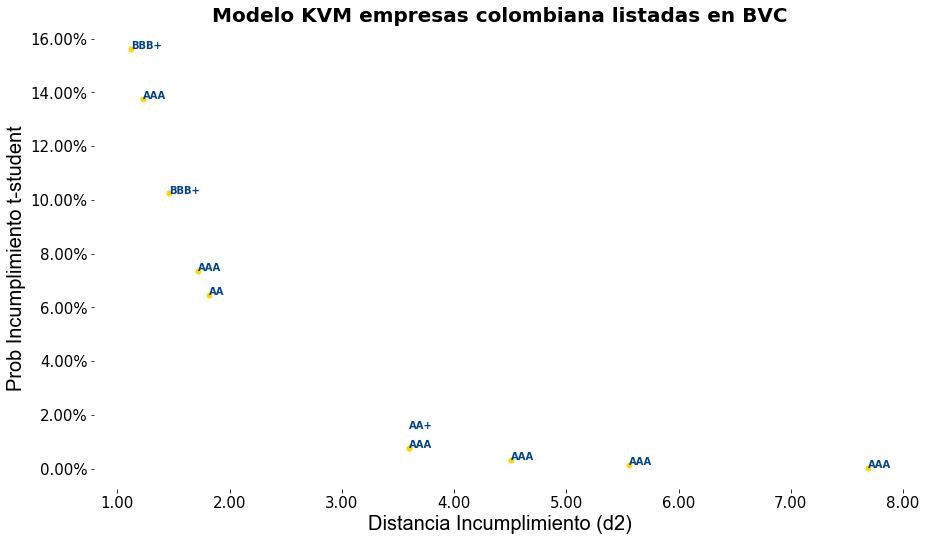

In [85]:
fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.plot(datos_empresas['d2'],datos_empresas['ProbIncump'],marker='o', linestyle='None',color='gold',markersize=5)
vals1 = ax1.get_yticks()
vals2 = ax1.get_xticks()
ax1.tick_params(axis='y', color = 'black', labelcolor='black')
ax1.set_yticklabels(['{:0,.2%}'.format(x) for x in vals1])
ax1.set_xticklabels(['{:0,.2f}'.format(x) for x in vals2])
ax1.set_xlabel('Distancia Incumplimiento (d2)',fontname = "Arial", fontsize=20,color='black')
ax1.set_ylabel('Prob Incumplimiento t-student',fontname = "Arial", fontsize=20,color='black')
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
plt.title('Modelo KVM empresas colombiana listadas en BVC',fontsize=20,weight="bold")

for i in range(0,datos_empresas.shape[0]):
    if datos_empresas['emisor'].iloc[i]=='GrupoArgosOrd':
        plt.text(datos_empresas['d2'].iloc[i], datos_empresas['ProbIncump'].iloc[i]+0.007, datos_empresas['Calificación'].iloc[i], color='#00448d', fontsize=10,weight='bold')
    else:
        plt.text(datos_empresas['d2'].iloc[i], datos_empresas['ProbIncump'].iloc[i], datos_empresas['Calificación'].iloc[i], color='#00448d', fontsize=10,weight='bold')

plt.subplots_adjust(wspace = 0.3,hspace = 0.8,bottom=0.1, right=2.0, top=1.7)
    
plt.show()

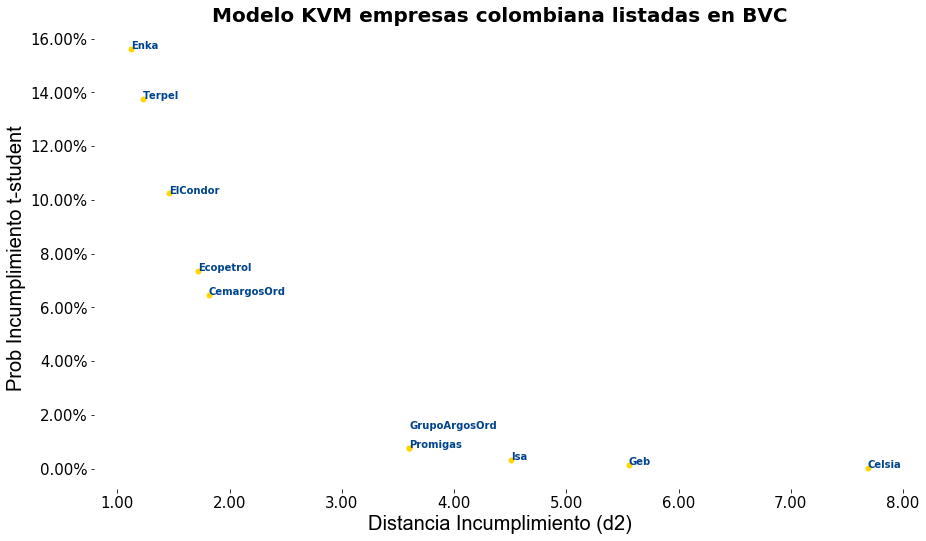

In [84]:
fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.plot(datos_empresas['d2'],datos_empresas['ProbIncump'],marker='o', linestyle='None',color='gold',markersize=5)
vals1 = ax1.get_yticks()
vals2 = ax1.get_xticks()
ax1.tick_params(axis='y', color = 'black', labelcolor='black')
ax1.set_yticklabels(['{:0,.2%}'.format(x) for x in vals1])
ax1.set_xticklabels(['{:0,.2f}'.format(x) for x in vals2])
ax1.set_xlabel('Distancia Incumplimiento (d2)',fontname = "Arial", fontsize=20,color='black')
ax1.set_ylabel('Prob Incumplimiento t-student',fontname = "Arial", fontsize=20,color='black')
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
plt.title('Modelo KVM empresas colombiana listadas en BVC',fontsize=20,weight="bold")

for i in range(0,datos_empresas.shape[0]):
    if datos_empresas['emisor'].iloc[i]=='GrupoArgosOrd':
        plt.text(datos_empresas['d2'].iloc[i], datos_empresas['ProbIncump'].iloc[i]+0.007, datos_empresas['emisor'].iloc[i], color='#00448d', fontsize=10,weight='bold')
    else:
        plt.text(datos_empresas['d2'].iloc[i], datos_empresas['ProbIncump'].iloc[i], datos_empresas['emisor'].iloc[i], color='#00448d', fontsize=10,weight='bold')

plt.subplots_adjust(wspace = 0.3,hspace = 0.8,bottom=0.1, right=2.0, top=1.7)
    
plt.show()

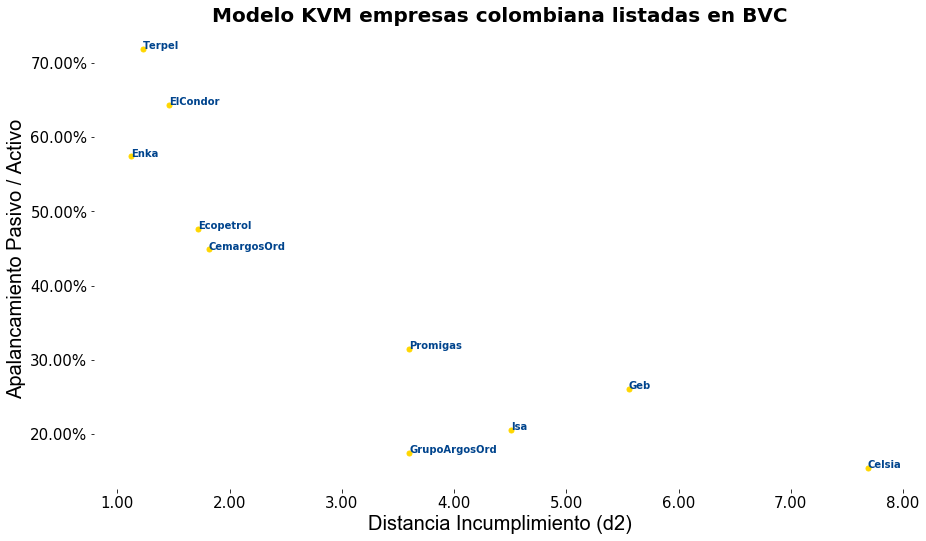

In [87]:
fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.plot(datos_empresas['d2'],datos_empresas['Pasivo']/datos_empresas['Activo'],marker='o', linestyle='None',color='gold',markersize=5)
vals1 = ax1.get_yticks()
vals2 = ax1.get_xticks()
ax1.tick_params(axis='y', color = 'black', labelcolor='black')
ax1.set_yticklabels(['{:0,.2%}'.format(x) for x in vals1])
ax1.set_xticklabels(['{:0,.2f}'.format(x) for x in vals2])
ax1.set_xlabel('Distancia Incumplimiento (d2)',fontname = "Arial", fontsize=20,color='black')
ax1.set_ylabel('Apalancamiento Pasivo / Activo',fontname = "Arial", fontsize=20,color='black')
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
plt.title('Modelo KVM empresas colombiana listadas en BVC',fontsize=20,weight="bold")

for i in range(0,datos_empresas.shape[0]):
    if datos_empresas['emisor'].iloc[i]=='GrupoArgosOrd':
        plt.text(datos_empresas['d2'].iloc[i], datos_empresas['Pasivo'].iloc[i]/datos_empresas['Activo'].iloc[i], datos_empresas['emisor'].iloc[i], color='#00448d', fontsize=10,weight='bold')
    else:
        plt.text(datos_empresas['d2'].iloc[i], datos_empresas['Pasivo'].iloc[i]/datos_empresas['Activo'].iloc[i], datos_empresas['emisor'].iloc[i], color='#00448d', fontsize=10,weight='bold')

plt.subplots_adjust(wspace = 0.3,hspace = 0.8,bottom=0.1, right=2.0, top=1.7)
    
plt.show()